In [ ]:
# Hui (Henry) Chen
# CSCI 415 - M01/ Fall 2020
# Project Part III
# Airbnb Open Data (NYC)

In [1]:
# config matplotlib display
%matplotlib notebook

import requests
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import norm
from scipy import stats

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

In [2]:
# config matplotlib style
plt.style.use('seaborn')

# initial val
DATASET_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/visualisations/listings.csv"
DATASET = ""
DATASET_LOCAL = "./dataset/listings.csv"

In [ ]:
def getDataSet():
    global DATASET

    # get the dataset file name
    fields = DATASET_URL.split("/")
    DATASET = str(fields[-1:][0])
    
    # download the dataset from the URL
    r = requests.get(DATASET_URL, allow_redirects=True)
    open(DATASET, 'wb').write(r.content)

In [3]:
# download the dataset remotely
# getDataSet()

df = pd.read_csv(DATASET_LOCAL)

In [ ]:
df.head(10)

In [ ]:
df.info()

### Analysis
Based on the info of the dataset, we can see that price can be compared with various features such as root_typ, number of reviews per month, and neighbourhood group.

In [ ]:
def Draw_RoomType_vs_price():
    plt.figure(figsize=(9, 6))
    plt.scatter(x=df['room_type'], y=df['price'])

    plt.title("Room Type vs Price",size=15, weight='bold')
    plt.xlabel("Room Type", size=12)
    plt.ylabel("Price", size=12)
    plt.tight_layout()
    plt.show()

In [ ]:
Draw_RoomType_vs_price()

As we can see from the scatter plot, "Hotel Room" is always less than $2000. Also, ther's an outlier in "Shared Room". Meanwhile, "Entrie Home/Apt" and "Private Room" have highest price in some.

Since the dataset has "neighbourhood_group" attribute, it is necessary to see the relationship with price as well.

In [ ]:
def Draw_RoomTypeGrp_vs_price():
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x="room_type", y="price", 
                    hue="neighbourhood_group", size="neighbourhood_group",
                    sizes=(11, 50), palette="Dark2", data=df)

    plt.title("Room Type vs Price vs Neighbourhood Grouping",size=15, weight='bold')
    plt.xlabel("Room Type", size=12)
    plt.ylabel("Price", size=12)
    plt.tight_layout()
    plt.show()

In [ ]:
Draw_RoomTypeGrp_vs_price()

Based on the grpah above, Manhattan is the Neighbourhood with the highest price in all root types. However, all of "Hotel Room" in Manhattan are less than $2000. Meanwhile, Brooklyn has very high price in "Entire home/apt" and "Shared Room". On the other hand, Queens has the highest price in "Private Room".

Now since the "neighbourhood_group", "neighbourhood", and "room_type" have fixed categories, we can convert these attributes to categories.

In [5]:
df['neighbourhood_group'] = df['neighbourhood_group'].astype("category").cat.codes
df['neighbourhood'] = df['neighbourhood'].astype("category").cat.codes
df['room_type'] = df['room_type'].astype("category").cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              44666 non-null  int64  
 1   name                            44650 non-null  object 
 2   host_id                         44666 non-null  int64  
 3   host_name                       44649 non-null  object 
 4   neighbourhood_group             44666 non-null  int8   
 5   neighbourhood                   44666 non-null  int16  
 6   latitude                        44666 non-null  float64
 7   longitude                       44666 non-null  float64
 8   room_type                       44666 non-null  int8   
 9   price                           44666 non-null  int64  
 10  minimum_nights                  44666 non-null  int64  
 11  number_of_reviews               44666 non-null  int64  
 12  last_review                     

<IPython.core.display.Javascript object>


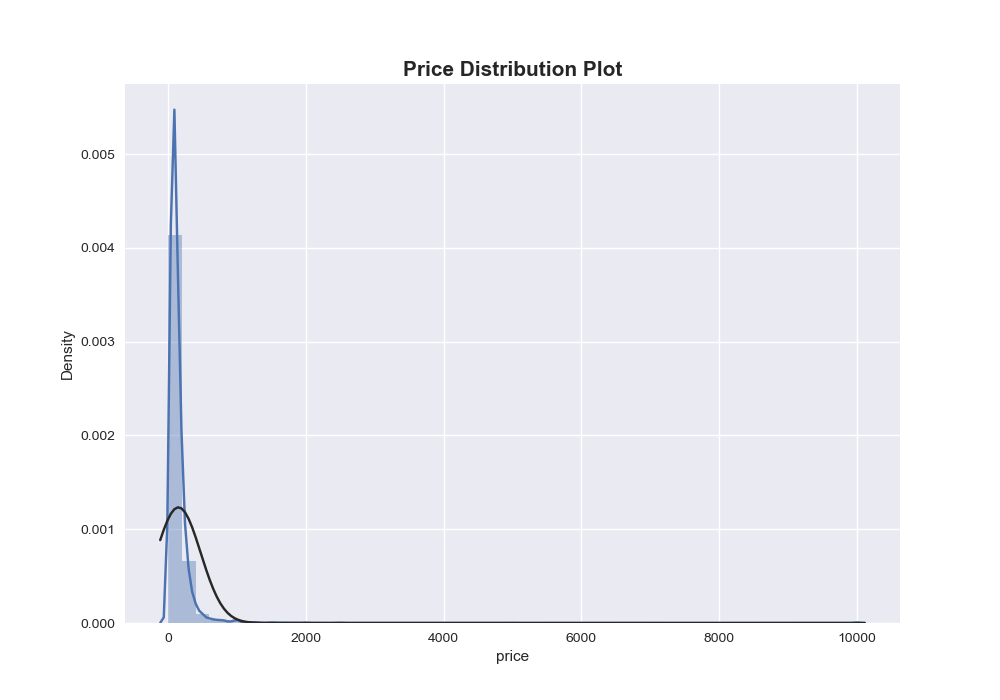

/home/hui/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensiona

Text(0.5, 1.0, 'Price Distribution Plot')

In [6]:
plt.figure(figsize=(10, 7))
sns.distplot(df['price'], fit=norm, kde=True)

# newer version use this method to demonstrate the data
# sns.displot(df['price'], hue_norm=norm, kde=True, height=5, aspect=12/5)

plt.title("Price Distribution Plot", size=15, weight='bold')

As we can see from the graph above, the distribution in price attribute is right skewed (aka positive skew). Therefore, we need to re-scaling the data by apply log normalization to price attribute in order to make analysis easier.

Since we can't log zero, therefore, we can use log + 1 to do the re-scaling.

In [7]:
df['price_log'] = np.log(df.price + 1)

In [ ]:
plt.figure(figsize=(12, 5))
sns.distplot(df['price_log'], fit=norm, kde=True)

# newer version use this method to demonstrate the data
# sns.displot(df['price_log'], hue_norm=norm, kde=True, height=8, aspect=12/5)

plt.title("Loggd Price Distribution Plot",size=15, weight='bold')

<IPython.core.display.Javascript object>


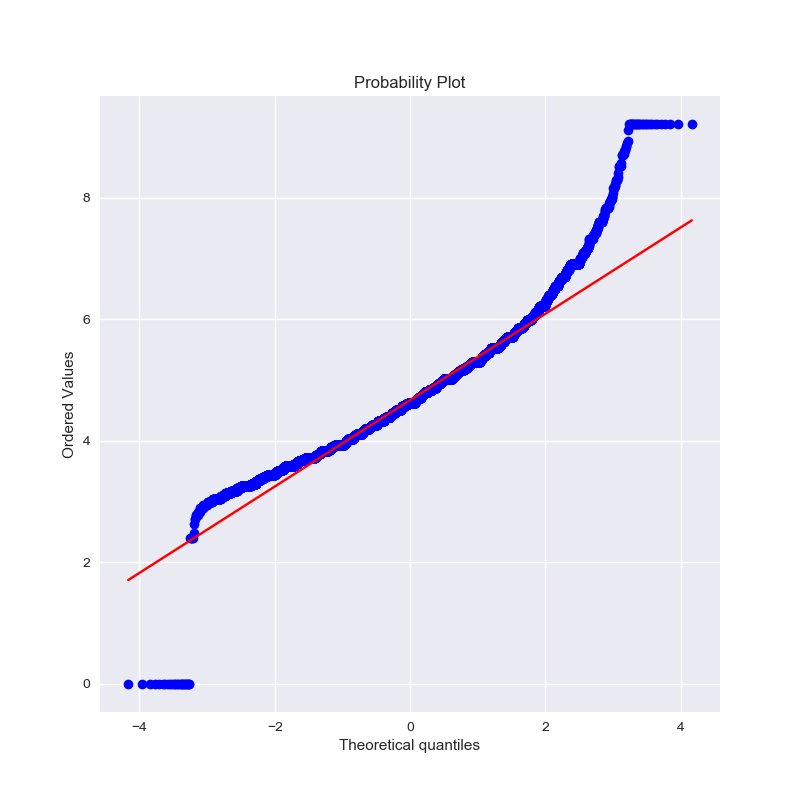

In [8]:
plt.figure(figsize=(8, 8))
stats.probplot(df['price_log'], plot=plt)
plt.show()

The normalization is reasonable since it covers most the plot in the graph. 

In [ ]:
def Find_MissingVal():
    # check the missing val
    missing_values_count = df.isnull().sum()
    total_cells = np.product(df.shape)
    total_missing = missing_values_count.sum()

    # percent of data that is missing
    percent_missing = (total_missing/ total_cells) * 100
    print("Missing values is: ", percent_missing, "%")